# Solución de validación
# $$\dfrac{\partial T}{\partial t} = \alpha \dfrac{\partial}{\partial x}\left[ D \dfrac{\partial T}{\partial x} \right] + \beta \dfrac{\partial T}{\partial x} + \varsigma$$ 

# $$q = - k \dfrac{\partial T}{\partial x}$$

La ecuación de transporte esta dada en su forma adimensional por medio de las siguientes variables adimensionales y parámetros:
* $T$ es la temperatura
* $t$ es el tiempo
* $x$ es la dirección espacial x
* $q$ es el flujo de calor
* $D$ es la difusividad térmica $D = k c^{-1}$
* Con $k$ la conductividad térmica y $c$ el producto de la densidad $\rho$ con la capacidad calofífica a volumen constante $C_v$
* El parámetro $\alpha$ es el número de Fourier $\alpha = D_0 t_0 L^{-2}$
* Con $t_0$ es el tiempo carácterisco, $D_0$ es la difusividad térmica de referencia del material y $L$ es la longitud del material
* El parámetro $\beta$ esta definido por $\beta = \alpha D \tfrac{\partial}{\partial x} \left[ \log (c) \right]$
* El parámetro $\varsigma$ es la interacción del sistema con el ambiente

Este problema en particular se va a resolver para las condiciones de frontera:
* $T(0, t) = 2 \quad$ y $\quad T(1, t) = 5$

La condición inicial
* $T(x, 0) = 2$


## Importación de bibliotecas
Estas bibliotecas son las necesarias para llevar a cabo la simulación

In [343]:
from IPython import display
import ipywidgets                # Barra de progreso
import numpy as np               # Cálculos numéricos basados en los arreglos numpy
import matplotlib.pyplot as plt  # Graficación
import scienceplots              # Estilos de graficacion
import seaborn as sns
from numba import jit            # Incrementa la velocidad de la simulación
from scipy import integrate      # Modulo de integracion
import modulo_fourier as mf      # Módulo que contiene las derivadas y el solver

## Opciones de graficación
Estética de las gráficas

In [344]:
sns.set_context("paper", font_scale = 1.5)
plt.style.use(["science", "grid"])

## Simulación

In [345]:
@jit(nopython = True)
def simulacion(interaccion, valfa, vbeta, dif, nt, nx, dt, dx):
    # Frontera
    frontera = 5
    # Condición inicial
    sol_temperatura = 2 * np.ones(nx + 1)
    # Simulacion
    for n in range(nt + 1):
        # Actualización de la frontera
        sol_temperatura[-1] = frontera
        # Calculo de la Temperatura
        sol_temperatura = mf.rungekutta(sol_temperatura, interaccion, valfa, vbeta, dif, dx, dt)
    #Devolver las series del flujo de calor del caso 1 y caso 2
    return sol_temperatura

## Dominio espacial

La solución numérica del problema se presenta solo en una dimensión espacial

In [346]:
nx = 256                        # Numero de pasos en el espacio
Lx = 1.0                        # Longitud del dominio espacial
x = np.linspace(0, Lx, nx + 1)  # Vector del dominio espacial, contiene nx+1 puntos incluyendo el 0
dx = x[1] - x[0]                # Tamaño de paso en el espacio
dx

0.00390625

## Dominio temporal

El tiempo que se pretende dar solución al sistema de ecuaciones

In [347]:
nt = 2_500_000                  # Numero de pasos en el tiempo
Lt = 25.0                       # Longitud del dominio temporal
t = np.linspace(0, Lt, nt + 1)  # Vector del dominio temporal, contiene nt+1 puntos incluyendo el 0
dt = t[1] - t[0]                # Tamaño de paso en el tiempo
dt

1e-05

## Construcción del material
### $D(x) \;$ y $\; \rho C_v$

In [348]:
difusividad = 0.5 * x + 0.2
denxcap = np.ones(nx + 1)

### Número de Fourier 
Como la conductividad/difusividad térmica adimensional ya está normalizada, se establece el término $D_0 = 1$

Si se quiere que $\alpha = 1$ entonces $t_0 = L^2 \Delta t_0^{-1}$

In [349]:
dif_0 = 1.0
dt_0 = (Lx ** 2) / dif_0
alfa = dif_0 * dt_0 / (Lx**2)
alfa

1.0

### Arreglos del número de Fourier $\alpha$
Los arreglos son del tamaño del dominio espacial, sin embargo, aunque son constantes, los extremos (valores a la frontera) son cero para no modificar las fronteras del problema

In [350]:
valfa = alfa * np.ones(nx + 1)  # Vector/arreglo alfa
valfa[0], valfa[-1] = 0, 0      # Extremos del vector/arreglo alfa

### Arreglos del parametro $\beta$
Los arreglos son del tamaño del dominio espacial, sin embargo, aunque son constantes, los extremos (valores a la frontera) son cero para no modificar las fronteras del problema

In [351]:
vbeta = valfa * difusividad * mf.ddx(np.log(denxcap), dx)  # Vector/arreglo beta

## Interacción con el ambiente
Para este caso, el sistema es cerrado

In [352]:
interaccion = np.zeros(nx + 1)

## Simulación

In [353]:
perfil_temperatura_numerico = simulacion(interaccion, valfa, vbeta, difusividad, nt, nx, dt, dx)

## Solución analítica

In [354]:
perfil_temperatura_analitico = 3 * (np.log(difusividad / 0.2) / np.log(0.7 / 0.2)) + 2

## Gráfica

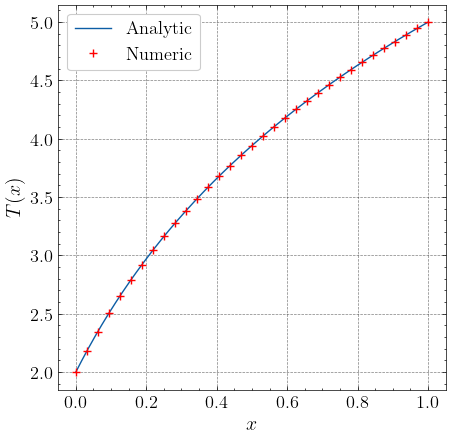

In [355]:
plt.figure(figsize = (5, 5))
plt.xlabel("$x$")
plt.ylabel("$T(x)$")
plt.plot(x, perfil_temperatura_analitico, lw = 1.0, label = "Analytic")
plt.plot(x[::8], perfil_temperatura_numerico[::8], color = "red", ls = "", marker = "+", ms = 5.5, label = "Numeric")
plt.legend(loc = "best")
plt.savefig("graficas/validacion.pdf", dpi = 300, bbox_inches = "tight")
plt.show()

## Error

In [356]:
error = np.abs(perfil_temperatura_analitico - perfil_temperatura_numerico).max()
error

0.00011290556371079674